## Code Modules & Functions

In [1]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np
import tensorflow_hub as th,tensorflow as tf
import os,pylab as pl
from keras.preprocessing import image as kimage
from tqdm import tqdm
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True 
fpath='../input/tomato-cultivars/'

Using TensorFlow backend.


In [2]:
def path_to_tensor(img_path,fpath=fpath):
    img=kimage.load_img(fpath+img_path, 
                        target_size=(160,160))
    x=kimage.img_to_array(img)
    return np.expand_dims(x,axis=0)
def paths_to_tensor(img_paths):
    tensor_list=[path_to_tensor(img_path) 
                 for img_path in tqdm(img_paths)]
    return np.vstack(tensor_list)

## Data

In [3]:
names=['Kumato','Beefsteak','Tigerella',
       'Roma','Japanese Black Trifele',
       'Yellow Pear','Sun Gold','Green Zebra',
       'Cherokee Purple','Oxheart','Blue Berries',
       'San Marzano','Banana Legs']
flist=sorted(os.listdir(fpath))
labels=np.array([int(el[:2]) for el in flist],
               dtype='int32')-1
images=np.array(paths_to_tensor(flist),
                dtype='float32')/255
N=labels.shape[0]; n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images,labels=images[shuffle_ids],labels[shuffle_ids]
x_test,x_valid,x_train=images[:n],images[n:2*n],images[2*n:]
y_test,y_valid,y_train=labels[:n],labels[n:2*n],labels[2*n:]

100%|██████████| 601/601 [00:03<00:00, 167.24it/s]


In [4]:
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

In [5]:
pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
              [x_train.dtype,x_valid.dtype,x_test.dtype],
              [y_train.shape,y_valid.shape,y_test.shape],
              [y_train.dtype,y_valid.dtype,y_test.dtype]],               
             columns=['train','valid','test'])

,train,valid,test
0,"(481, 160, 160, 3)","(60, 160, 160, 3)","(60, 160, 160, 3)"
1,float32,float32,float32
2,"(481,)","(60,)","(60,)"
3,int32,int32,int32


Label:  0 Kumato


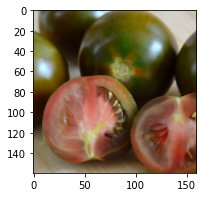

In [6]:
k=np.random.randint(40)
print('Label: ',y_test[k],
      names[y_test[k]])
pl.figure(figsize=(3,3))
pl.imshow((x_test[k]));

## NN Examples

In [7]:
fw='weights.best.hdf5'
def premodel(pix,den,mh,lbl,activ,loss):
    model=tf.keras.Sequential([
        tf.keras.layers.Input((pix,pix,3),
                              name='input'),
        th.KerasLayer(mh,trainable=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(den,activation='relu'),
        tf.keras.layers.Dropout(rate=.5),
        tf.keras.layers.Dense(lbl,activation=activ)])
    model.compile(optimizer='adam',
                  metrics=['accuracy'],loss=loss)
    display(model.summary())
    return model
def cb(fw):
    early_stopping=tf.keras.callbacks\
    .EarlyStopping(monitor='val_loss',patience=20,verbose=2)
    checkpointer=tf.keras.callbacks\
    .ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
    lr_reduction=tf.keras.callbacks\
    .ReduceLROnPlateau(monitor='val_loss',verbose=2,
                       patience=5,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

In [8]:
[handle_base,pixels]=["inception_v3",160]
mhandle="https://tfhub.dev/google/imagenet/{}/classification/4"\
.format(handle_base)

In [9]:
model=premodel(pixels,1024,mhandle,13,
               'softmax','sparse_categorical_crossentropy')
history=model.fit(x=x_train,y=y_train,batch_size=16,
                  epochs=70,callbacks=cb(fw),
                  validation_data=(x_valid,y_valid))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              23853833  
_________________________________________________________________
flatten (Flatten)            (None, 1001)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1026048   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                13325     
Total params: 24,893,206
Trainable params: 24,858,774
Non-trainable params: 34,432
_________________________________________________________________


None

Epoch 1/70
31/31 [==============================] - ETA: 0s - loss: 3.5634 - accuracy: 0.1372
Epoch 00001: val_loss improved from inf to 19263.69922, saving model to weights.best.hdf5
31/31 [==============================] - 6s 183ms/step - loss: 3.5634 - accuracy: 0.1372 - val_loss: 19263.6992 - val_accuracy: 0.0500 - lr: 0.0010
Epoch 2/70
30/31 [============================>.] - ETA: 0s - loss: 2.7367 - accuracy: 0.3021
Epoch 00002: val_loss improved from 19263.69922 to 471.15244, saving model to weights.best.hdf5
31/31 [==============================] - 3s 105ms/step - loss: 2.7623 - accuracy: 0.3015 - val_loss: 471.1524 - val_accuracy: 0.0833 - lr: 0.0010
Epoch 3/70
30/31 [============================>.] - ETA: 0s - loss: 2.8580 - accuracy: 0.3750
Epoch 00003: val_loss improved from 471.15244 to 187.74551, saving model to weights.best.hdf5
31/31 [==============================] - 3s 106ms/step - loss: 2.8913 - accuracy: 0.3742 - val_loss: 187.7455 - val_accuracy: 0.0500 - lr: 0.001

In [10]:
model.load_weights(fw)
model.evaluate(x_test,y_test)

2/2 [==============================] - 0s 161ms/step - loss: 1.3375 - accuracy: 0.7000


[1.337517261505127, 0.699999988079071]

In [11]:
[handle_base,pixels]=["mobilenet_v2_100_160",160]
mhandle="https://tfhub.dev/google/imagenet/{}/classification/4"\
.format(handle_base)

In [12]:
model=premodel(pixels,1024,mhandle,13,
               'softmax','sparse_categorical_crossentropy')
history=model.fit(x=x_train,y=y_train,batch_size=16,
                  epochs=70,callbacks=cb(fw),
                  validation_data=(x_valid,y_valid))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              3540265   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1001)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1026048   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 13)                13325     
Total params: 4,579,638
Trainable params: 4,545,526
Non-trainable params: 34,112
_________________________________________________________________


None

Epoch 1/70
31/31 [==============================] - ETA: 0s - loss: 2.7159 - accuracy: 0.4054
Epoch 00001: val_loss improved from inf to 9.55723, saving model to weights.best.hdf5
31/31 [==============================] - 4s 114ms/step - loss: 2.7159 - accuracy: 0.4054 - val_loss: 9.5572 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/70
30/31 [============================>.] - ETA: 0s - loss: 1.9829 - accuracy: 0.5729
Epoch 00002: val_loss improved from 9.55723 to 6.16980, saving model to weights.best.hdf5
31/31 [==============================] - 2s 68ms/step - loss: 1.9853 - accuracy: 0.5717 - val_loss: 6.1698 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 3/70
30/31 [============================>.] - ETA: 0s - loss: 1.1655 - accuracy: 0.7063
Epoch 00003: val_loss did not improve from 6.16980
31/31 [==============================] - 2s 52ms/step - loss: 1.1687 - accuracy: 0.7048 - val_loss: 11.9668 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 4/70
30/31 [============================>.] - ETA: 0s 

In [13]:
model.load_weights(fw)
model.evaluate(x_test,y_test)

2/2 [==============================] - 0s 64ms/step - loss: 0.8356 - accuracy: 0.8167


[0.8355739712715149, 0.8166666626930237]